In [4]:
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
LOGS_FOLDER = "/mnt/c/Users/Diego/Documents/Università/alphazero_singleplayer/logs/RaceStrategy-v2/results"
DATA_FOLDER = "trpo_2_32_200e"
directory = os.path.join(LOGS_FOLDER, DATA_FOLDER)
dfs = defaultdict(dict)
for entry in tqdm(os.scandir(directory)):
    if entry.is_file:
        filename = entry.name
        filename = filename[:-4]
        tokens = filename.split('_')
        timestamp = tokens.pop(0)
        df = pd.read_csv(entry.path)
        dfs[tokens[0] + "_" + timestamp][tokens[2]] = df
        dfs[tokens[0] + "_" + timestamp]['year'] = tokens[1]

400it [00:01, 215.90it/s]


In [8]:
database = pd.DataFrame(columns=['race', 'year', 'lap', 'driver', 'lap_time', 'cumulative_time', 'influence', 'position', 'id'])
index = 0
df_list = [database]
for race_id in tqdm(dfs):
    tokens = race_id.split('_')
    timestamp = tokens[1]
    race = tokens[0]
    year = dfs[race_id]['year']

    lap_times = dfs[race_id]['laptimes']
    influences = dfs[race_id]['lapinfluences']
    positions = dfs[race_id]['positions']
    race_times = dfs[race_id]['racetimes']
    
    columns = list(lap_times.columns)
    columns.remove('lap')

    for lap in lap_times.lap.unique():
        lap_time_single_lap = lap_times.loc[lap_times['lap'] == lap]
        influences_single_lap = influences.loc[influences['lap'] == lap]
        positions_single_lap = positions.loc[positions['lap'] == lap]
        race_times_single_lap = race_times.loc[race_times['lap'] == lap]
        for col in columns:
            index += 1
            new_df = {}
            new_df['id'] = [timestamp]
            new_df['race'] = [race]
            new_df['year'] = [year]
            new_df['lap'] = [lap]
            new_df['driver'] = [col]
            new_df['lap_time'] = lap_time_single_lap[col].values
            new_df['influence'] = influences_single_lap[col].values
            new_df['cumulative_time'] = race_times_single_lap[col].values
            new_df['position'] = positions_single_lap[col].values
            new_df = pd.DataFrame(new_df, index=[index])
            df_list.append(new_df)
database = pd.concat(df_list)


database.describe()


100%|██████████| 100/100 [02:32<00:00,  1.52s/it]


,lap_time,cumulative_time
count,132000.000000,132000.000000
mean,91.369011,3073.652239
std,5.825201,1747.688716
min,83.697000,92.865000
25%,88.912000,1560.219000
50%,90.014000,3049.648500
75%,91.292250,4600.164500
max,137.198000,6218.591000


In [9]:
database

,race,year,lap,driver,lap_time,cumulative_time,influence,position,id
1,Catalunya,2017,1,VAN,101.331,101.331,none,15,1603103610672
2,Catalunya,2017,1,RIC,97.331,97.331,none,6,1603103610672
3,Catalunya,2017,1,VET,94.486,94.486,none,2,1603103610672
4,Catalunya,2017,1,RAI,96.531,96.531,none,4,1603103610672
5,Catalunya,2017,1,GRO,99.331,99.331,none,10,1603103610672
...,...,...,...,...,...,...,...,...,...
131996,Catalunya,2017,66,VER,93.773,6131.129,none,19,1603108828049
131997,Catalunya,2017,66,HAM,86.668,5861.415,none,1,1603108828049
131998,Catalunya,2017,66,SAI,87.695,6011.272,none,6,1603108828049
131999,Catalunya,2017,66,BOT,91.637,5981.097,none,4,1603108828049


<AxesSubplot:xlabel='lap', ylabel='lap_time'>

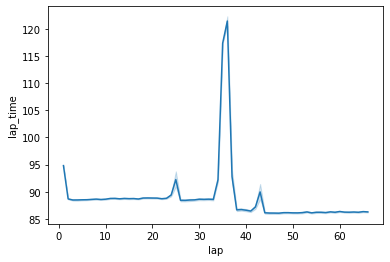

In [10]:
vettel = database.loc[(database['driver'] == 'VET') & (database['race'] == 'Catalunya')]
vettel = vettel.sort_values('lap')
pits = []
for index, row in vettel.iterrows():
    if 'pitinlap' in row['influence']:
        pits.append(row['lap'])
sns.lineplot(data=vettel, y='lap_time', x='lap')
#plt.ylim([85, 95])

In [14]:
len(pits)/len(vettel['id'].unique())

2.0

In [7]:
vettel['position'] = vettel['position'].astype(int)
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.0
mean,87.194800,5927.900000,2.0
std,0.458159,4.854732,0.0
min,86.043000,5917.000000,2.0
25%,86.886250,5924.750000,2.0
50%,87.267000,5928.500000,2.0
75%,87.606500,5931.250000,2.0
max,87.694000,5935.000000,2.0


In [40]:
vettel['position'] = vettel['position'].astype(int)
vettel['cumulative_time'] = vettel['cumulative_time'].astype(int)
vettel[vettel['lap'] == vettel['lap'].max()].describe()

,lap_time,cumulative_time,position
count,20.000000,20.000000,20.000000
mean,86.300050,5889.150000,1.950000
std,0.485724,5.499043,0.223607
min,85.593000,5880.000000,1.000000
25%,85.878750,5883.000000,2.000000
50%,86.273500,5890.500000,2.000000
75%,86.724750,5893.250000,2.000000
max,87.166000,5897.000000,2.000000


In [ ]:
sns.distplot(vettel['position'])

In [13]:
import numpy as np
import matplotlib.pyplot as plt
online_scores = np.load('../data/RaceStrategy-v2/trpo_2_32_0.001_201e/models/2020-10-17_15-51_58/online_scores.npy')
offline_scores = np.load('../data/RaceStrategy-v2/trpo_2_32_0.001_201e/models/2020-10-17_15-51_58/offline_scores.npy', allow_pickle=True)
print(offline_scores)

[[ 7.50258546  0.          2.92        3.22        3.04        0.        ]
 [ 7.50993029  0.          7.06        4.26        3.8         0.        ]
 [ 7.53875727  0.          6.66        4.22        6.          0.        ]
 [ 7.58185088  0.          7.82        2.9        14.08        0.        ]
 [ 7.71437293  0.         12.48        1.12       32.24        0.        ]]


<AxesSubplot:>

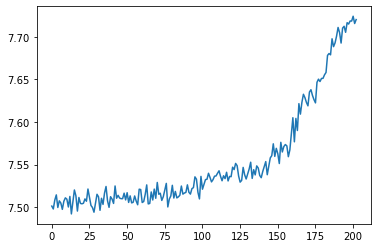

In [14]:
sns.lineplot(data=online_scores)

In [16]:
offline_scores

array([[ 7.50258546,  0.        ,  2.92      ,  3.22      ,  3.04      ,
         0.        ],
       [ 7.50993029,  0.        ,  7.06      ,  4.26      ,  3.8       ,
         0.        ],
       [ 7.53875727,  0.        ,  6.66      ,  4.22      ,  6.        ,
         0.        ],
       [ 7.58185088,  0.        ,  7.82      ,  2.9       , 14.08      ,
         0.        ],
       [ 7.71437293,  0.        , 12.48      ,  1.12      , 32.24      ,
         0.        ]])

In [15]:
sns.lineplot(data=offline_scores[:, 0])
plt.title("Return per epoch")

import numpy as np

lower_bound = online_scores[:, 0] - online_scores[:, 1]
upper_bound = online_scores[:, 0] + online_scores[:, 1]

plt.fill_between(np.arange(200) , lower_bound, upper_bound, alpha=.3)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed